In [1]:
import warnings
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
from   datetime          import timedelta

warnings.simplefilter(action='ignore', category=FutureWarning)

<Axes: xlabel='datetime'>

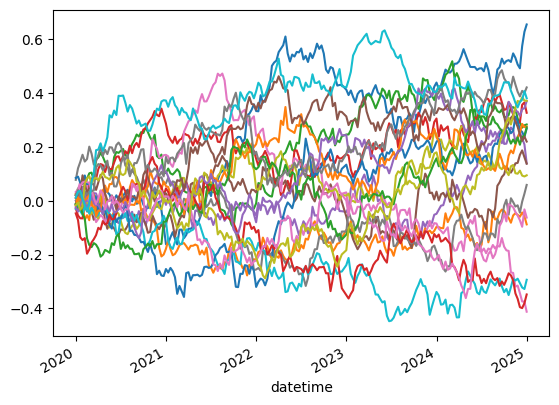

In [2]:
# Preparing data for portfolio

num_securities = 20
num_periods    = 200
start_date     = pd.to_datetime('2020-01-01')
end_date       = pd.to_datetime('2024-12-31')

trade_dates    = pd.to_datetime(np.sort(np.random.choice(pd.date_range(start=start_date, end=end_date, periods=num_periods + 1), num_periods, replace=False)))

df = pd.DataFrame({'datetime'  : trade_dates})
df['datetime' ] = pd.to_datetime(df['datetime'])
df['datetime_'] = df['datetime']
df = df.set_index('datetime')

outliers_percentage = 20.0
outliers_percentage = outliers_percentage/100.0 # percentage of all returns are outliers
outliers_count      = int(num_periods*outliers_percentage)

for idx in range(0, num_securities):
    percentage_changes = np.random.uniform(-0.033, 0.033, num_periods).astype(float)
    extreme_returns    = np.random.uniform(-0.08 , 0.09 , outliers_count).astype(float)
    outliers_date      = df['datetime_'].sample(n=outliers_count).to_list()
    df[f"return_{idx}"] = percentage_changes
    for outlier in list(zip(outliers_date, extreme_returns)):
        outlier_dt  = outlier[0]
        outlier_ret = outlier[1]
        df.loc[outlier_dt, f"return_{idx}"] = outlier_ret
    df[f"cum_ret_{idx}"] = df[f"return_{idx}"].cumsum()

df.drop('datetime_', axis=1, inplace=True)

df.filter(like='cum_ret_').plot(legend=False)

In [3]:
initial_cash     = 100000 # 100K USD

In [4]:
# no rebalancing portfolio

allocated_cash = initial_cash/num_securities

for idx in range(0, num_securities):
    df[f"cash_path_{idx}"] = (1+df[f"return_{idx}"]).cumprod()*(allocated_cash)

df['raw_portfolio_cash_path'] = df[[col_name for col_name in df.columns if col_name.startswith("cash")]].sum(axis=1)
df['raw_portfolio_return'   ] = df['raw_portfolio_cash_path'].pct_change()
df['raw_portfolio_cumret'   ] = df['raw_portfolio_return'].cumsum()

In [5]:
# weekly equally weighted rebalancing portfolio

rebalancing_cost = 0.001  # 0.1% aka 10bps as rebalancing cost
rebalancing_freq = 'W'    # Weekly rebalancing

rebalanced_dates            = []
rebalanced_portfolio_values = []

current_portfolio_value     = initial_cash
for date, group in df.groupby(pd.Grouper(freq=rebalancing_freq)):
    group_df = group.copy()
    allocated_cash = current_portfolio_value/num_securities
    for idx in range(0, num_securities):
        group_df[f"rebalanced_cash_path_{idx}"] = (1+group_df[f"return_{idx}"]).cumprod()*(allocated_cash)
    if not group_df.empty:
        rebalanced_cash_cols = [col_name for col_name in group_df.columns if col_name.startswith("rebalanced_cash_path")]
        current_portfolio_value = group_df.iloc[-1][rebalanced_cash_cols].sum()
        rebalanced_dates.append(date)
        rebalanced_portfolio_values.append(current_portfolio_value)

rebalanced_df       = pd.DataFrame(index=rebalanced_dates)
rebalanced_df.index = pd.to_datetime(rebalanced_df.index)
rebalanced_df['value' ] = rebalanced_portfolio_values
rebalanced_df['return'] = rebalanced_df['value'].pct_change()
rebalanced_df.dropna(inplace=True)


rebalancing_cost_log = np.log(1-rebalancing_cost)
rebalanced_df['log_return'         ] = (1+rebalanced_df['return']).apply(np.log)
rebalanced_df['adjusted_log_return'] = rebalanced_df['log_return'] + rebalancing_cost_log

rebalanced_df['cum_ret'         ] = rebalanced_df['log_return'         ].cumsum().apply(np.exp)
rebalanced_df['adjusted_cum_ret'] = rebalanced_df['adjusted_log_return'].cumsum().apply(np.exp)

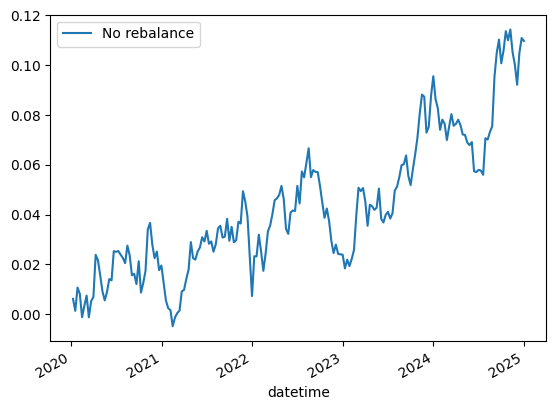

In [6]:
df['raw_portfolio_cumret'].plot()
plt.legend(['No rebalance'])

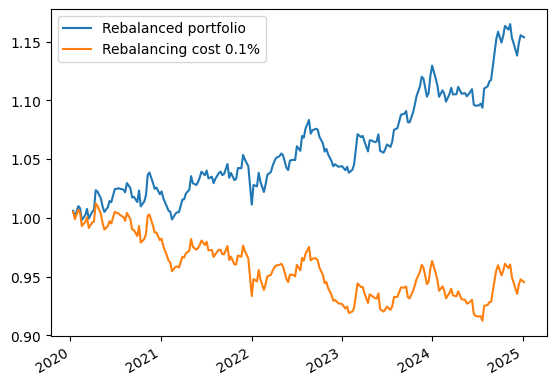

In [7]:
rebalanced_df[['cum_ret', 'adjusted_cum_ret']].plot()
plt.legend(['Rebalanced portfolio', f"Rebalancing cost {round(rebalancing_cost*100,2)}%"])